## Word Embedding

### GOAL: use 3 chars to predict the following one

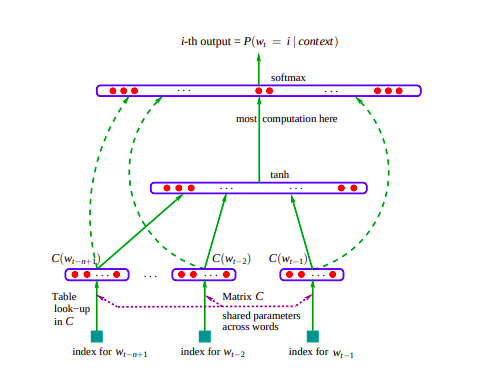

In [1]:
import torch
import torch.nn.functional as F

In [2]:
# 1. create the dataset
words = open('names.txt', 'r').read().splitlines()
words[:8]

['emma', 'olivia', 'ava', 'isabella', 'sophia', 'charlotte', 'mia', 'amelia']

In [3]:
# char to integer mapping
chars = sorted(list(set(''.join(words))))
stoi = {s:i+1 for i,s in enumerate(chars)}
stoi["."] = 0 

# integer to char mapping
itos = {i:s for s,i in stoi.items()}

In [4]:
xs = []; ys = []

In [5]:
BLOCK_SIZE = 3

for word in words[:5]:
    contxt = [0]*BLOCK_SIZE
    for ch in word+".":
        i = stoi[ch]
        xs.append(contxt)
        ys.append(stoi[ch])
        print(f"{contxt} --> {ch}")
        contxt = contxt[1:] + [i]
        

[0, 0, 0] --> e
[0, 0, 5] --> m
[0, 5, 13] --> m
[5, 13, 13] --> a
[13, 13, 1] --> .
[0, 0, 0] --> o
[0, 0, 15] --> l
[0, 15, 12] --> i
[15, 12, 9] --> v
[12, 9, 22] --> i
[9, 22, 9] --> a
[22, 9, 1] --> .
[0, 0, 0] --> a
[0, 0, 1] --> v
[0, 1, 22] --> a
[1, 22, 1] --> .
[0, 0, 0] --> i
[0, 0, 9] --> s
[0, 9, 19] --> a
[9, 19, 1] --> b
[19, 1, 2] --> e
[1, 2, 5] --> l
[2, 5, 12] --> l
[5, 12, 12] --> a
[12, 12, 1] --> .
[0, 0, 0] --> s
[0, 0, 19] --> o
[0, 19, 15] --> p
[19, 15, 16] --> h
[15, 16, 8] --> i
[16, 8, 9] --> a
[8, 9, 1] --> .


In [6]:
xs = torch.tensor(xs)
ys = torch.tensor(ys)

### what's next
inputs to neural networks cannot be words, so we use what's called `embeddings` which transforms words into numbers  
first layer is just the embeddings  
the input is the raw `x` (string of 3 letters) -> output is the 2 numbers for each letter -> total of 6


what to expect when we do `X @ C`?
> x is for example `27*3` for each row the output is `3*2` ---> total of `27*6`  but then we wanna separate each 2 outputs such that output is 

In [7]:
g = torch.Generator().manual_seed(2147483647) 
C = torch.randn((27, 2), generator=g, requires_grad=True)

In [8]:
print(xs.shape)
print(C.shape)

torch.Size([32, 3])
torch.Size([27, 2])


In [9]:
# h = F.one_hot(xs, num_classes=27).to(torch.float32) @ C equivalent to C[x]
embeddings = C[xs]
embeddings.shape # for each letter in the 32*3 matrix -> the output is 1*2

torch.Size([32, 3, 2])

In [10]:
HIDDEN_LAYER_SIZE = 100
W1 = torch.randn((6, HIDDEN_LAYER_SIZE), generator=g, requires_grad=True)
b1 = torch.randn(HIDDEN_LAYER_SIZE, generator=g, requires_grad=True)
h =  torch.tanh(embeddings.view((-1, 6)) @ W1 + b1)
# 32 6 @ 6 100 = 32 * 100
# 32 100
# 1  100

In [11]:
W2 = torch.randn((HIDDEN_LAYER_SIZE, 27), generator=g, requires_grad=True)
b2 = torch.randn(27, generator=g, requires_grad=True)

# NOTE: You must set requires_grad=True before you compute logits and loss.
params = [C, W1, b1, W2, b2]
    
sum(param.nelement() for param in params)

logits = h @ W2 + b2
loss = F.cross_entropy(logits, ys)
loss

tensor(17.7697, grad_fn=<NllLossBackward0>)

In [12]:
lr = 0.1
# backward pass:
for param in params:
    param.grad = None
loss.backward()

for param in params:
    param.data -= lr * param.grad

In [13]:
loss.item()

17.76971435546875

In [14]:
# putting everything together:
for _ in range(1000):
    # forward pass:
    embeddings = C[xs]
    h =  torch.tanh(embeddings.view((-1, 6)) @ W1 + b1)
    logits = h @ W2 + b2
    loss = F.cross_entropy(logits, ys)
    
    # backward pass:
    for param in params:
        param.grad = None
    loss.backward()

    for param in params:
        param.data -= lr * param.grad
    print(loss.item())
    

13.656401634216309
11.298768997192383
9.452455520629883
7.984262466430664
6.891321182250977
6.100014686584473
5.452036380767822
4.898151874542236
4.414664268493652
3.985848903656006
3.6028308868408203
3.2621419429779053
2.961381196975708
2.6982977390289307
2.469712972640991
2.271660327911377
2.101283550262451
1.9571774005889893
1.8374857902526855
1.7380965948104858
1.6535115242004395
1.579089879989624
1.5117665529251099
1.4496047496795654
1.3913120031356812
1.335992455482483
1.283052921295166
1.2321909666061401
1.18338143825531
1.1367990970611572
1.092664122581482
1.0510923862457275
1.0120267868041992
0.9752704501152039
0.9405565857887268
0.9076125025749207
0.8761921525001526
0.8460890650749207
0.817135751247406
0.7891992330551147
0.7621746063232422
0.7359814047813416
0.7105579972267151
0.6858609318733215
0.6618651747703552
0.6385656595230103
0.6159818172454834
0.5941657423973083
0.5732105374336243
0.553256094455719
0.5344880819320679
0.5171167254447937
0.5013312697410583
0.48724257946